In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import random_rotation, random_shift
import matplotlib.pyplot as plt
import os

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
NUM_CHANNELS = 3
IMAGE_DIR = '../PlantVillage/'

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [5]:
print(len(dataset) * 32)

16032


In [8]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    '''
    Splits dataset into training, validation, and test groups.
    
    Args:
        ds: dataset
        train_split: proportion of data allocated for training
        val_split: proportion of data allocated for validation
        test_split: proportion of data allocated for testing
        shuffle: whether or not to shuffle
        shuffle_size: number of iterations of shuffling
    Returns:
        Partitioned dataset
    '''
    ds_size = len(ds)
    
    # shuffling
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
        
    # partitioning
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = split_dataset(dataset)
print(type(train_ds))

<class 'tensorflow.python.data.ops.take_op._TakeDataset'>


In [11]:
def preprocess_dataset(ds):
    ds = ds.cache()
    ds = ds.shuffle(1000)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [12]:
train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)
test_ds = preprocess_dataset(test_ds)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [19]:
augment_data = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

In [31]:
model = models.Sequential([
    resize_and_rescale,
    augment_data,
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.25),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(len(class_names), activation='softmax'),
])

# Build the model
model.build(input_shape=(BATCH_SIZE, None, None, 3))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy'],
)

# Print model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_49 (Conv2D)          (32, 252, 252, 32)        2432      
                                                                 
 average_pooling2d_7 (Avera  (32, 126, 126, 32)        0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_7 (Bat  (32, 126, 126, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_50 (Conv2D)          (32, 124, 124, 32)      

In [ ]:
model_history = model.fit(train_ds, epochs=60, batch_size=BATCH_SIZE, validation_data=val_ds)

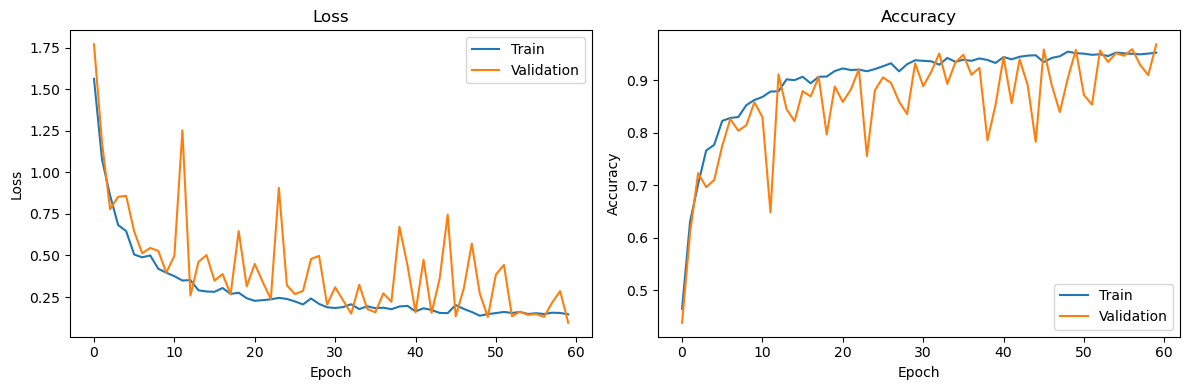

In [22]:
import matplotlib.pyplot as plt

# Get the training and validation loss from the history object
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Get the training and validation accuracy from the history object
train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

# Create subplots for loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()